# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert (narms > 0),"narms must be positive integers"
        assert (type(epsilon)==float),"epsilon must be floating number"
        
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.arm_visit_count = {}
        self.arm_total_reward = {}
        
        self.arm_with_Q = {}
        for arm in range(1,self.narms+1):
            self.arm_with_Q[arm]=self.Q0 #Initial all the arm with Q0
            
            self.arm_visit_count[arm]=0 #Initial all the arm with zero number of visits
            self.arm_total_reward[arm] = 0 #Initial all the arm with zero reward
            
        
    def play(self, tround, context=None):
        assert (tround > 0),"tround must be positive integers"
        if np.random.random() <self.epsilon: #exploration(Random select an arm)
            action = np.random.choice(self.narms)
        else:                               #Select the arm with highest Q value 
            #Getting the highest value from Q, then find the corresponding key and append them
            highest = max(self.arm_with_Q.values())
            highest_Qs = [key for key, value in self.arm_with_Q.items() if value == highest]
            if len(highest_Qs)>1:
                action = np.random.choice(highest_Qs)#Tie Breaker
            else:
                action = highest_Qs[0]
         
        return action
        
        
    def update(self, arm, reward, context=None):
        assert (arm > 0 and arm <=self.narms),"arm must be positive integers and no larger than self.narms"
        assert (type(reward)==float or type(reward) == np.float64),"reward must be floating point"
        self.arm_visit_count[arm] += 1
        self.arm_total_reward[arm] += reward
        updated_reward = self.arm_total_reward[arm]/self.arm_visit_count[arm]#From lecture 13 slide pg7 
        
        self.arm_with_Q.update({arm:updated_reward})
        
        return self.arm_with_Q
        
        
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert (narms > 0),"narms must be positive integers"
        assert (type(rho)==float and rho >0.0 and np.isreal(rho)),"rho must be positive real floating number"
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.arm_visit_count = {}
        self.arm_total_reward = {}
        
        self.arm_with_avg_reward = {}
        for arm in range(1,self.narms+1):
            self.arm_with_avg_reward[arm]=self.Q0 #Initial all the arm with Q0
            
            self.arm_visit_count[arm]=0 #Initial all the arm with zero number of visits
            self.arm_total_reward[arm] = 0  #Initial all the arm with zero reward
        
    
    def play(self, tround, context=None):
        assert (tround > 0),"tround must be positive integers"
        #copy each arm with reward for later calculation at tround
        temp_arm_with_Q = self.arm_with_avg_reward
        
        for arm in temp_arm_with_Q:
            if self.arm_visit_count[arm] == 0: #Use Q0 for the first round
                continue
                
                
            else:
                #At tround, calculate Q with exlpore boost for each arm
                explore_boost_const = self.rho*np.log(tround)/self.arm_visit_count[arm]
                
                temp_arm_with_Q[arm] = temp_arm_with_Q[arm] + np.sqrt(explore_boost_const)
            
       #Getting the highest value from Q, then find the corresponding key and append them
        highest = max(temp_arm_with_Q.values())
        highest_Qs = [key for key, value in temp_arm_with_Q.items() if value == highest]
        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs)#Tie Breaker
        else:
            action = highest_Qs[0]
        return action
        
    def update(self, arm, reward, context=None):
        assert (arm > 0 and arm <=self.narms),"arm must be positive integers and no larger than self.narms"
        assert (type(reward)==float or type(reward) == np.float64),"reward must be floating point"
        #same as e-greedy
        self.arm_visit_count[arm] += 1
        self.arm_total_reward[arm] += reward
        updated_reward = self.arm_total_reward[arm]/self.arm_visit_count[arm]
        
        self.arm_with_avg_reward.update({arm:updated_reward})
        
        return self.arm_with_avg_reward
        
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        assert (narms > 0),"narms must be positive integers"
        assert (type(alpha0)==float and alpha0 >0.0 and np.isreal(alpha0)),"alpha0 must be real positive floating number"
        assert (type(beta0)==float and beta0 >0.0 and np.isreal(beta0)),"beta0 must be real positive floating number"
        
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.theta = np.random.beta(self.alpha0, self.beta0) #Initial theta based on default alpha and beta
        
        
        self.arm_with_theta = {}
        self.arm_with_alpha0 = {}
        self.arm_with_beta0 = {}
        
        for arm in range(1,self.narms+1):
            self.arm_with_theta[arm]=self.theta #Initial all the arm with theta
            self.arm_with_alpha0[arm]=self.alpha0 #Initial all the arm with default alpha0
            self.arm_with_beta0[arm]=self.beta0 #Initial all the arm with default beta0
            
        
        
    
    def play(self, tround, context=None):
        assert (tround > 0),"tround must be positive integers"
        for arm in range(1,self.narms+1):
            #For each arm, calculate theta
            self.arm_with_theta[arm] = np.random.beta(self.arm_with_alpha0[arm]+1, self.arm_with_beta0[arm]+1)
        #Getting the highest value from theta, then find the corresponding key and append them
        highest = max(self.arm_with_theta.values())
        highest_Qs = [key for key, value in self.arm_with_theta.items() if value == highest]
        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs)#Tie Breaker
        else:
            action = highest_Qs[0]
        return action
        
        
        
    def update(self, arm, reward, context=None):
        assert (arm > 0 and arm <=self.narms),"arm must be positive integers and no larger than self.narms"
        assert (type(reward)==float or type(reward) == np.float64),"reward must be floating point"
        #update alpha if there is a reward, in other case update beta.
        if reward ==1:
            self.arm_with_alpha0[arm] += 1
        else:
            self.arm_with_beta0[arm] += 1
        

## 3. Off-Policy Evaluation

In [6]:
#Initial three lists which respects
# to arm, reward, and context(feature_list in this case).
arm_list = []
reward_list = []
features_list = []
num_of_events = 0

#Read each line and split by spaces. Record arm, reward and context into the lists
with open("dataset.txt","r") as f:
    dataset = f.readlines()
for line in dataset:
    num_of_events += 1
    temp_line = line.split()
    arm = int(temp_line[0])
    reward = float(temp_line[1])
    features = temp_line[2:]
    features = list(map(float, features))
    arm_list.append(arm)
    reward_list.append(reward)
    features_list.append(features)
    
#Convert lists into np_array
arms = np.array(arm_list)
rewards = np.array(reward_list)

#For each event, the context is 10*10 dim 
# because there are 10 arms, and each one of them has 10 features 
contexts = np.array(features_list).reshape(num_of_events,(10*10))



    
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    assert(arms.shape==(num_of_events,)),"1d array and in range[1...map.narms]"
    assert(rewards.shape==(num_of_events,)),"must be 1d array"
    assert(nrounds >0 or nrounds is None),"must be positive integer with default None"
    h0 = [] #History list 
    R0 = [] #Total Payoff
        
    count = 0
    for event in range(num_of_events):
        #If reach required number of rounds then stop
        #If number of rounds not specified, then read untill last of events. 
        if len(h0) == nrounds: 
            
            break
        #Play an arm, but the tround is the number of history observed
        action = mab.play(len(h0)+1,contexts[event])
        
        #If the chosen arm is equal to the arm in the log, 
        # then record history and payoff, and also update the arm.
        if action == arms[event]:
            count +=1
            h0.append(event)
            R0.append(rewards[event])
            mab.update(arms[event],rewards[event],contexts[event])
        
    
    return R0
            

        
    

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print(len(results_EpsGreedy))
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

800
EpsGreedy average reward 0.24875


In [8]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.0925


In [9]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.225


## 4. Contextual Bandits - LinUCB

In [10]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert (narms > 0),"narms must be positive integers"
        assert (ndims > 0),"ndims must be positive integers"
        assert ((type(alpha)==float or type(alpha) == np.float64) and alpha >0.0 and np.isreal(alpha)),"alpha must be real positive floating number"
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha

        
        self.A_a = {} #A is the list of each arm with D.T * D + I 
        self.b_a = {} #b is the reward list
        
        
        for arm in range(1,self.narms+1):
            if arm not in self.A_a:#If arm is new
                #For each arm, initial identity matrix with feature dimensitonal space 
                self.A_a[arm] = np.identity(self.ndims)  
            if arm not in self.b_a:
                #For each arm, initial reward matrix with zeros. Dimension is each corresponding context's dimension
                self.b_a[arm] = np.zeros(self.ndims)
            
         
            
        
        
    def play(self, tround, context):
        assert (tround > 0),"tround must be positive integers"
        
        assert (context.shape == (self.narms*self.ndims,)),"context must be a numeric array of length self.ndims * self.narms"
        arm_with_Q = {} #At tround, initial arm with empty posterior distribution
        
        context = context.reshape(self.narms,self.ndims)
        
        for arm in range(1,self.narms+1):
            #For each arm, calculate posterior distribution based on theta and std
            Theta_a = np.dot(np.linalg.inv(self.A_a[arm]),self.b_a[arm])
            std = np.sqrt(np.linalg.multi_dot([np.transpose(context[arm-1]),np.linalg.inv(self.A_a[arm]),context[arm-1]]))
            p_ta = np.dot(Theta_a.T,context[arm-1]) + self.alpha*std
            
            if not np.isnan(p_ta):#make sure the result of calculation is valid number
                arm_with_Q[arm] = p_ta
            
        #Getting the highest value from posterior distribution, then find the corresponding key and append them
        highest = max(arm_with_Q.values())
        
        highest_Qs = [key for key, value in arm_with_Q.items() if value == highest]
        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs)#Tie Breaker
        else:
            action = highest_Qs[0]
        
        return action
        
            
            
        
        
        
    
    def update(self, arm, reward, context):
        assert (arm > 0 and arm <=self.narms),"arm must be positive integers and no larger than self.narms"
        assert (type(reward)==float or type(reward) == np.float64),"reward must be floating point"
        
        assert (context.shape == (self.narms*self.ndims,)),"context must be a numeric array of length self.ndims * self.narms"
        
        context = context.reshape(self.narms,self.ndims)
        
        
        if arm <= self.narms:
            #Reshap the vector to matrix, or the calculation will be incorrect 
            #because the transpose will not take effects
            context_Matrix = context[arm-1].reshape(-1,1)
            context_times_contextT = np.dot(context_Matrix,context_Matrix.T)
            
            self.A_a[arm] = np.add(self.A_a[arm],context_times_contextT)
            
            self.b_a[arm] = np.add(self.b_a[arm],np.dot(reward,context[arm-1]))
            
            
        
        
    

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [12]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        assert (narms > 0),"narms must be positive integers"
        assert (ndims > 0),"ndims must be positive integers"
        assert ((type(v)==float or type(alpha) == np.float64) and v >0.0 and np.isreal(v)),"v must be real positive floating number"
        self.narms = narms
        self.ndims = ndims
        self.v = v 
        
        
        self.B = np.identity(self.ndims) #Initial B with identity matrix which has ndims dimension
        
        
        self.f = np.zeros(self.ndims) #Initial total payoff with ndims of zeros
        
        
        self.u = np.zeros(self.ndims) #Initial parameter mu with ndims of zeros
        
       
            
                
        
        
    def play(self, tround, context):
        assert (tround > 0),"tround must be positive integers"
        assert (context.shape == (self.narms*self.ndims,)),"context must be a numeric array of length self.ndims * self.narms"
        
        arm_with_Q = {}
        
        context = context.reshape(self.narms,self.ndims)
        #Calculate prior from multivariate Gaussian distribution
        u_t = np.random.multivariate_normal(self.u, self.v*self.v*np.linalg.inv(self.B))
        
        for arm in range(1,self.narms+1):
            #calculate posterior distribution for each arm
            arm_with_Q[arm] = np.dot(np.transpose(context[arm-1]),u_t)
            
        #Getting the highest value from posterior distribution, then find the corresponding key and append them
        highest = max(arm_with_Q.values())
        highest_Qs = [key for key, value in arm_with_Q.items() if value == highest]
        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs)#Tie Breaker
        else:
            action = highest_Qs[0]
        return action
            
        
    
    def update(self, arm, reward, context):
        assert (arm > 0 and arm <=self.narms),"arm must be positive integers and no larger than self.narms"
        assert (type(reward)==float or type(reward) == np.float64),"reward must be floating point"
        assert (context.shape == (self.narms*self.ndims,)),"context must be a numeric array of length self.ndims * self.narms"
        
        context = context.reshape(self.narms,self.ndims)

        if arm <= self.narms:
            #Reshap the vector to matrix, or the calculation will be incorrect 
            #because the transpose will not take effects
            context_Matrix = context[arm-1].reshape(-1,1)
            context_times_contextT = np.dot(context_Matrix,context_Matrix.T)
            #Update B
            self.B = np.add(self.B,context_times_contextT)
            #Update reward f
            self.f = np.add(self.f,np.multiply(reward,context[arm-1]))
            #Update mu
            self.u = np.dot(np.linalg.inv(self.B),self.f)

    

In [13]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.32


## 6. Evaluation
### 6.A.

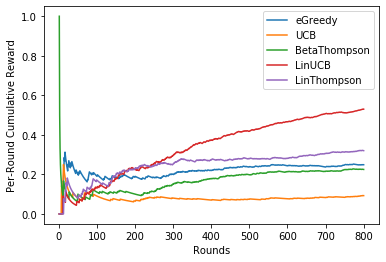

In [14]:
EpsGreedy_reward = []
UCB_reward = []
betaThompson_reward = []
linUCB_reward = []
linThompson_reward = []
total_round = []
count = 0
for round in range(1,801):
    count +=1
    total_round.append(count)
    if round ==1: #calculate initial reward 
        EpsGreedy_reward.append(results_EpsGreedy[round-1]/round)
        UCB_reward.append(results_UCB[round-1]/round)
        betaThompson_reward.append(results_BetaThompson[round-1]/round)
        linUCB_reward.append(results_LinUCB[round-1]/round)
        linThompson_reward.append(results_LinThompson[round-1]/round)
    else: #calculate cumulated reward
        results_EpsGreedy[round-1] += results_EpsGreedy[round-2] 
        EpsGreedy_reward.append(results_EpsGreedy[round-1]/round)
        
        results_UCB[round-1]+= results_UCB[round-2]
        UCB_reward.append(results_UCB[round-1]/round)
        
        results_BetaThompson[round-1]+= results_BetaThompson[round-2]
        betaThompson_reward.append(results_BetaThompson[round-1]/round)
        
        results_LinUCB[round-1]+= results_LinUCB[round-2]
        linUCB_reward.append(results_LinUCB[round-1]/round)
        
        results_LinThompson[round-1] += results_LinThompson[round-2]
        linThompson_reward.append(results_LinThompson[round-1]/round)
        
plt.plot(total_round,EpsGreedy_reward, label = "eGreedy")
plt.plot(total_round,UCB_reward, label = "UCB")
plt.plot(total_round,betaThompson_reward, label = "BetaThompson")
plt.plot(total_round,linUCB_reward, label = "LinUCB")
plt.plot(total_round,linThompson_reward, label = "LinThompson")
plt.ylabel('Per-Round Cumulative Reward')
plt.xlabel('Rounds')
plt.legend()
plt.show()

### 6.B.

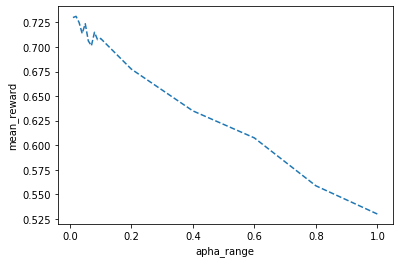

In [15]:
#First Interval [0.2 0.4 0.6 0.8 1. ]
alpha_range_one_decimal = np.linspace(0,1,6) 
alpha_range_one_decimal = np.delete(alpha_range_one_decimal,0)#delete zero
#Second Interval [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
alpha_range_two_decimal = np.linspace(0,0.1,11)
alpha_range_two_decimal = np.delete(alpha_range_two_decimal,0)#delete zero
#Append two intervals and sort
alpha_range = np.append(alpha_range_two_decimal,alpha_range_one_decimal) 
alpha_range = np.sort(alpha_range)
results_LinUCB_with_alpha = []

for alpha in alpha_range:
    mab = LinUCB(10, 10, alpha)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results_LinUCB_with_alpha.append(np.mean(results_LinUCB))
   
    
plt.plot(alpha_range, results_LinUCB_with_alpha,linestyle='dashed')
plt.ylabel('mean_reward')
plt.xlabel('apha_range')

plt.show()

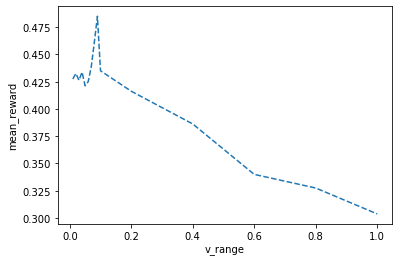

In [16]:
#First Interval [0.2 0.4 0.6 0.8 1. ]
v_range_one_decimal = np.linspace(0,1,6)
v_range_one_decimal = np.delete(v_range_one_decimal,0)#delete zero
#Second Interval [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
v_range_two_decimal = np.linspace(0,0.1,11)
v_range_two_decimal = np.delete(v_range_two_decimal,0)#delete zero
#Append two intervals and sort
v_range = np.append(v_range_two_decimal,v_range_one_decimal) 
v_range = np.sort(v_range)

resutls_LinThompson_with_v = []
for v in v_range:
    mab = LinThompson(10, 10,v)
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
    resutls_LinThompson_with_v.append(np.mean(results_LinThompson))
plt.plot(v_range, resutls_LinThompson_with_v,linestyle='dashed')
plt.ylabel('mean_reward')
plt.xlabel('v_range')

plt.show()